In [63]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.dpi"] = 256

## 讀取資料

In [64]:
df = pd.read_excel('Online_Retail001.xlsx')

In [65]:
df.shape

(10000, 8)

In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom


In [67]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10000.000000,10000,10000.000000,7526.000000
mean,10.158300,2011-07-02 06:06:49.842000128,3.881760,15266.947250
min,-600.000000,2010-12-01 08:45:00,0.000000,12347.000000
25%,1.000000,2011-03-24 13:10:00,1.250000,13908.000000
50%,3.000000,2011-07-15 14:05:00,2.080000,15128.000000
75%,12.000000,2011-10-17 15:06:15,4.130000,16759.000000
max,4000.000000,2011-12-09 12:50:00,736.380000,18283.000000
std,57.905129,NaN,14.863321,1704.574949


發現問題：

- `Quantity` 有負數，需要進一步處理
- `CustomerID` 的資料和 Quantity 等其他欄位的 `count` 不同，大概有問題。

## 資料清理 ⭐

針對 quantity 進行處理

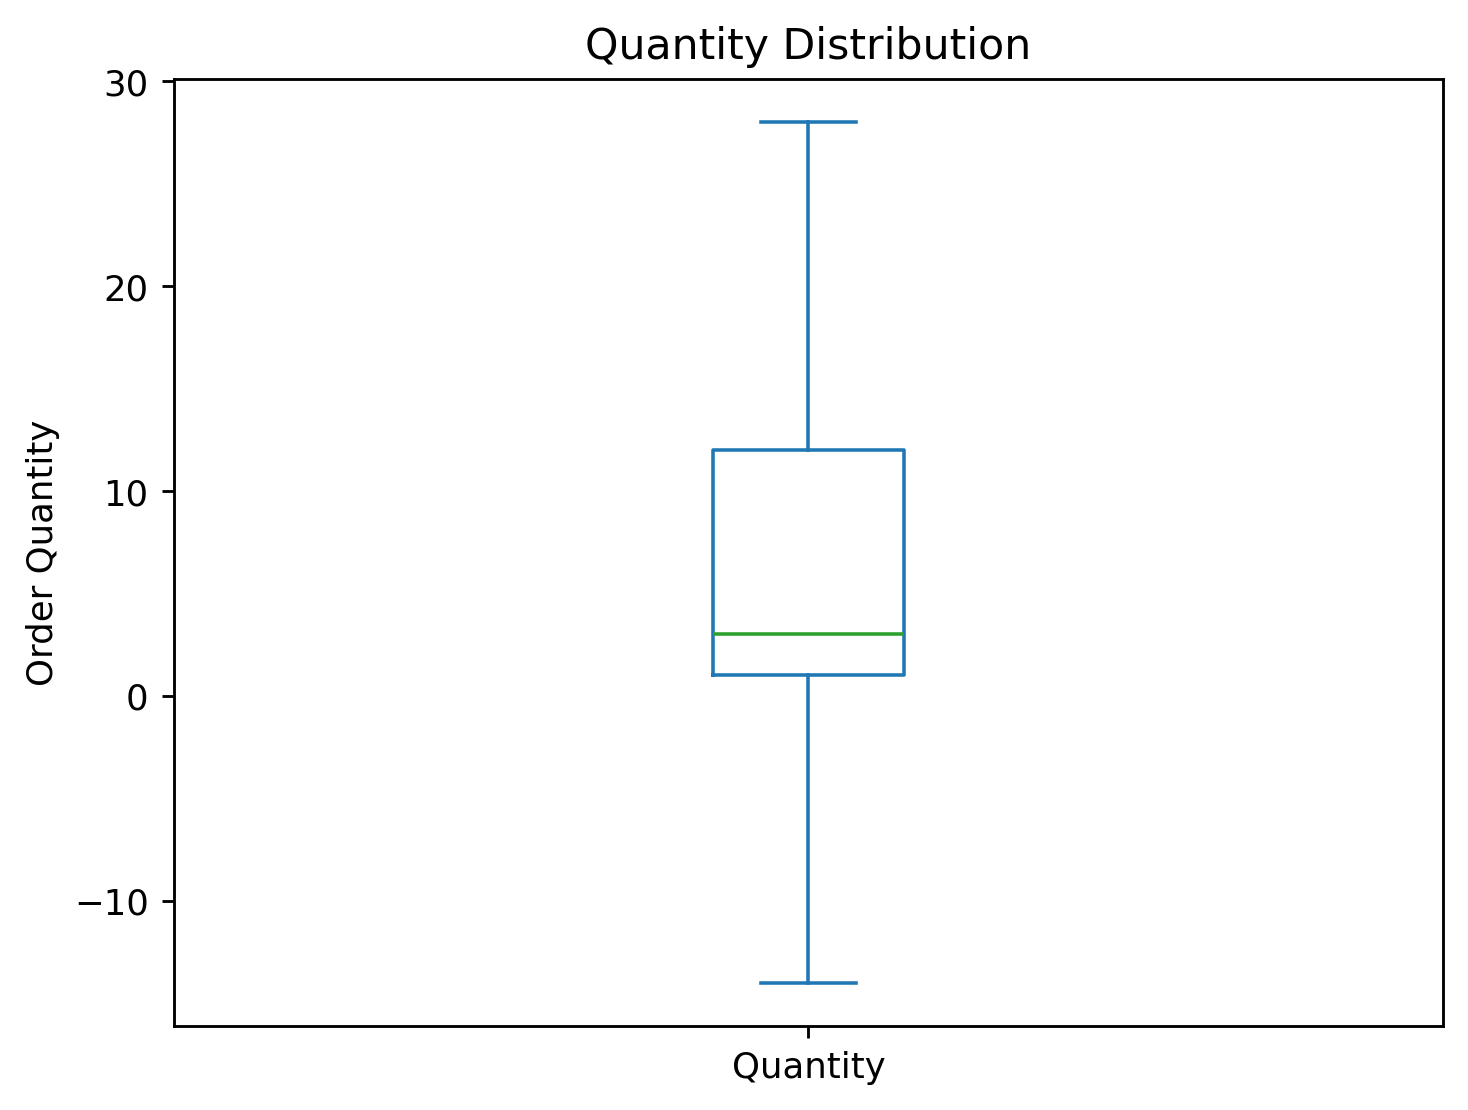

In [68]:
df['Quantity'].plot(kind='box', showfliers=False)
plt.ylabel('Order Quantity')
plt.title('Quantity Distribution')
plt.show()

去除小於 0 的資料。

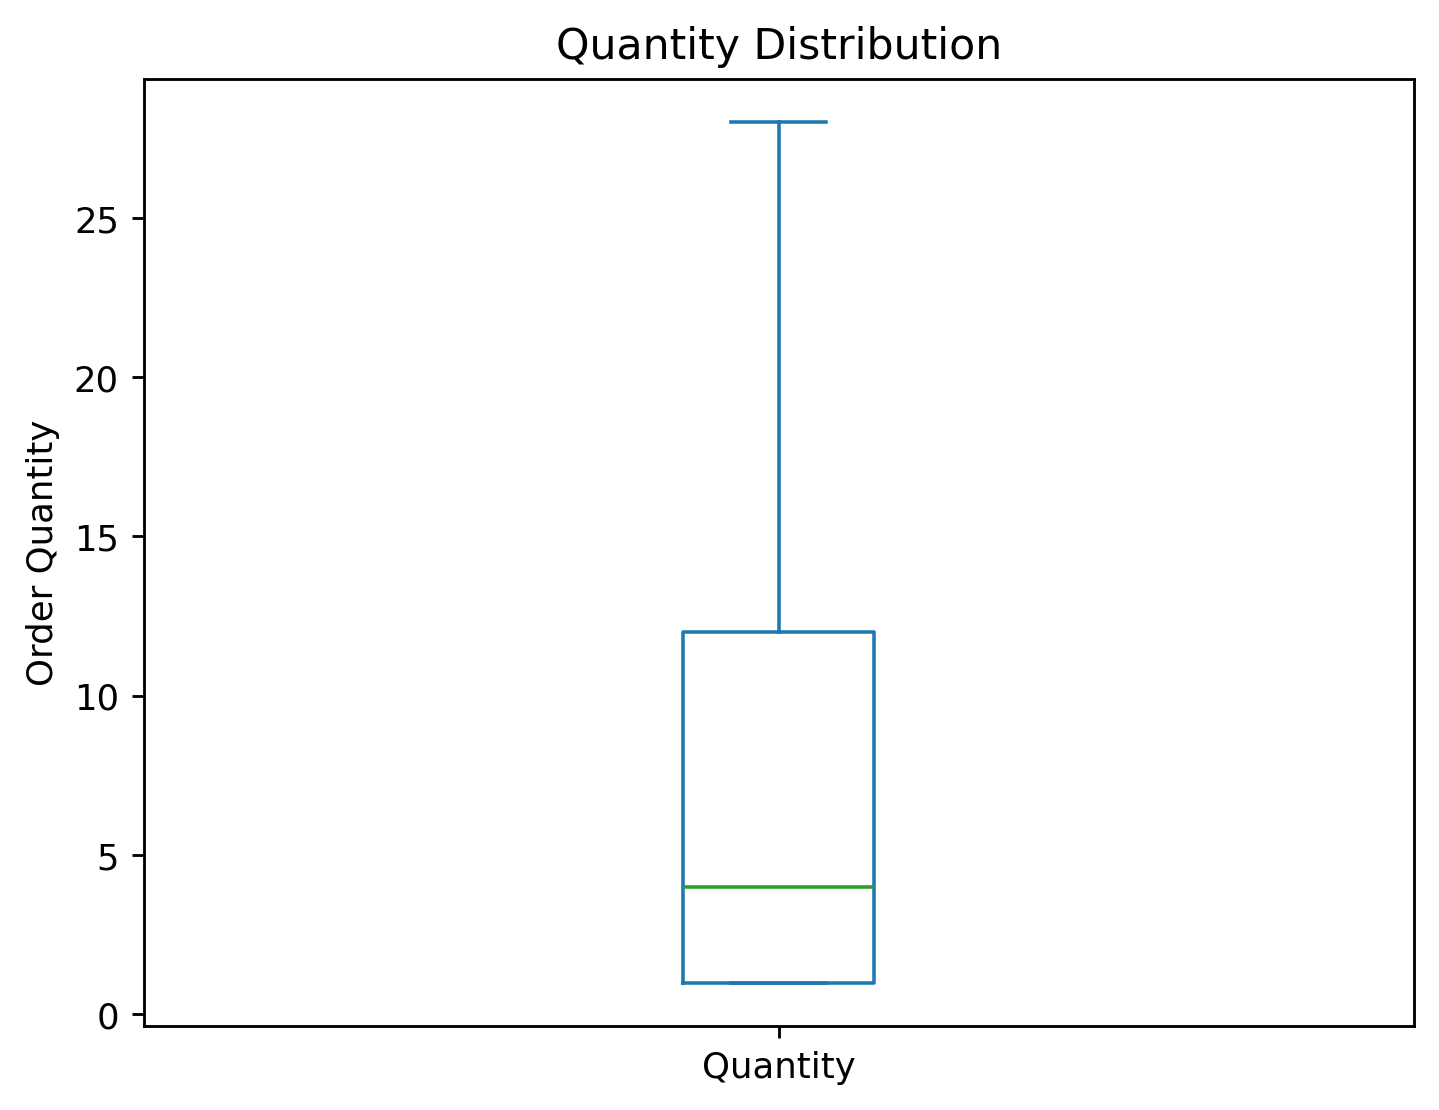

In [69]:
df = df[df['Quantity'] > 0]
df['Quantity'].plot(kind='box', showfliers=False)
plt.ylabel('Order Quantity')
plt.title('Quantity Distribution')
plt.show()

接著處理空值的 CustomerID。

In [70]:
df['CustomerID'].isnull().value_counts()

CustomerID
False    7349
True     2442
Name: count, dtype: int64

In [71]:
df.dropna(subset=['CustomerID'], inplace=True)
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,7349.000000,7349,7349.000000,7349.000000
mean,12.666349,2011-07-07 20:03:14.108041728,2.962449,15269.442373
min,1.000000,2010-12-01 08:45:00,0.001000,12347.000000
25%,2.000000,2011-04-03 15:22:00,1.250000,13923.000000
50%,6.000000,2011-07-24 11:54:00,1.950000,15128.000000
75%,12.000000,2011-10-18 15:22:00,3.750000,16764.000000
max,2880.000000,2011-12-09 12:50:00,300.000000,18283.000000
std,45.978377,NaN,5.326559,1705.369038


## 產品分析

### 每個月的訂單數量

In [72]:
monthly_orders_df = df.set_index('InvoiceDate').resample('ME')['InvoiceNo'].nunique()
monthly_orders_df

InvoiceDate
2010-12-31    385
2011-01-31    299
2011-02-28    272
2011-03-31    384
2011-04-30    294
2011-05-31    393
2011-06-30    384
2011-07-31    375
2011-08-31    335
2011-09-30    525
2011-10-31    572
2011-11-30    799
2011-12-31    218
Freq: ME, Name: InvoiceNo, dtype: int64

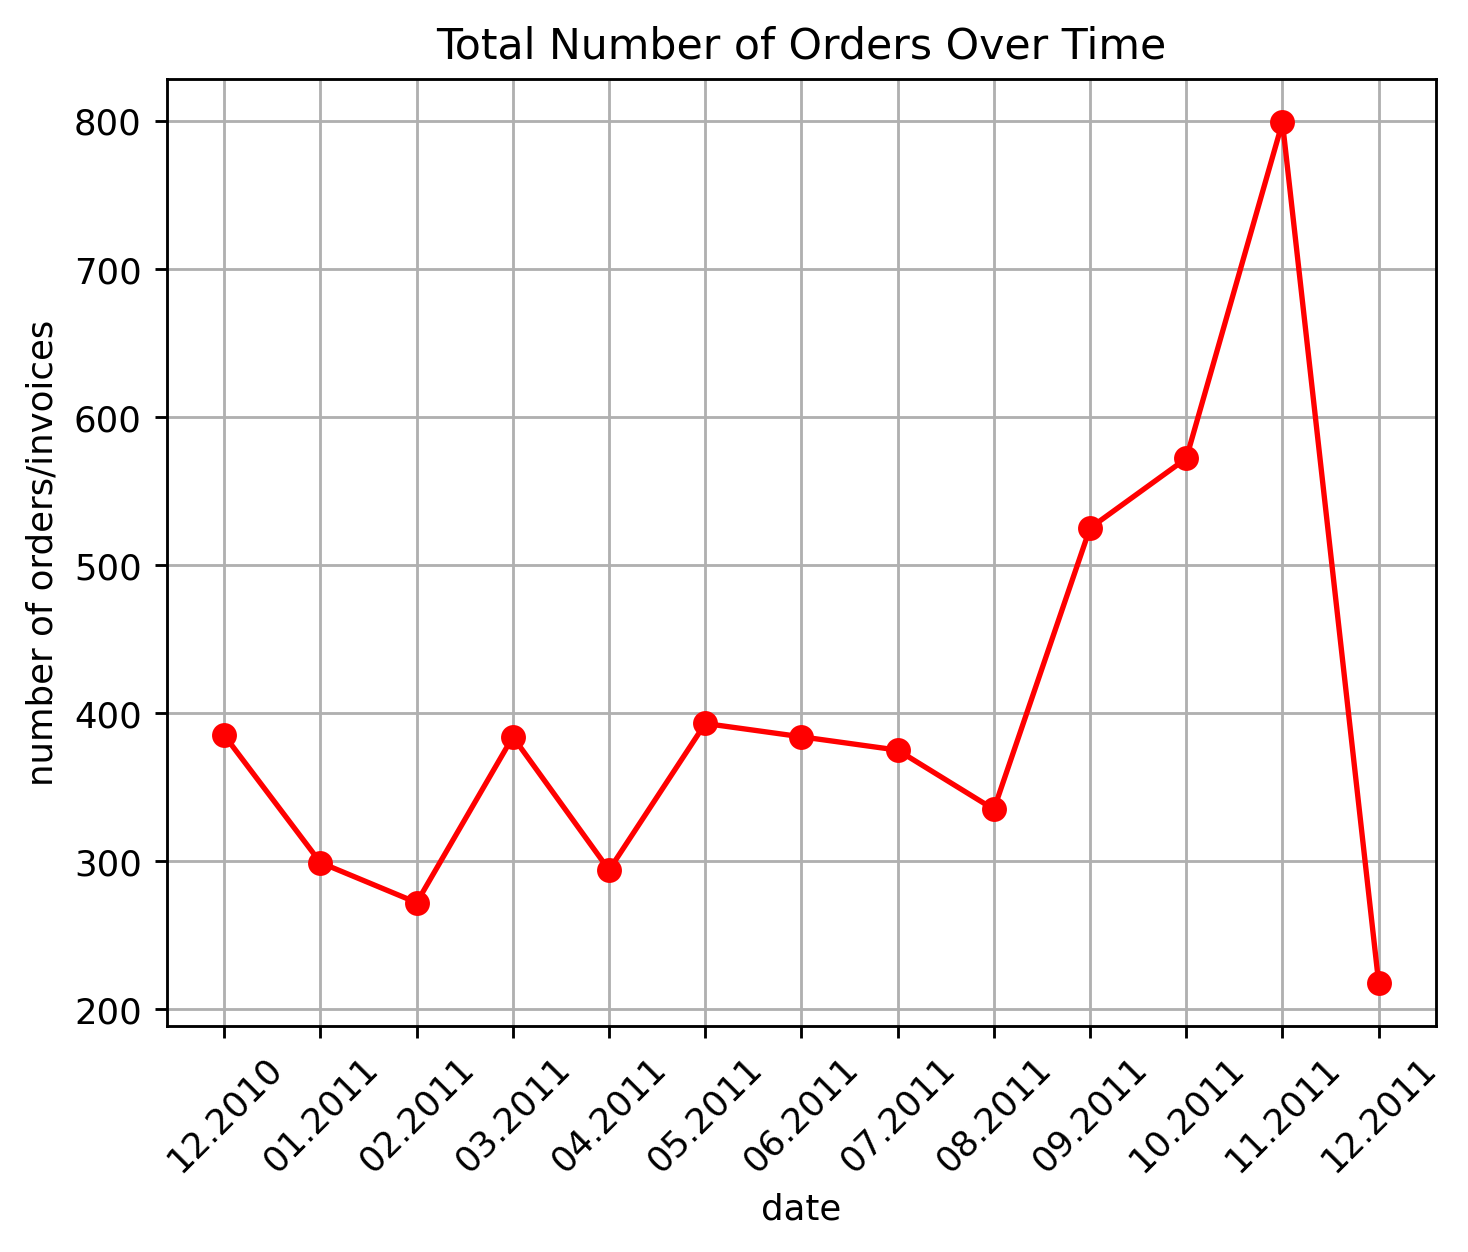

In [73]:
plt.xlabel('date')
plt.ylabel('number of orders/invoices')
plt.title('Total Number of Orders Over Time')

plt.plot(monthly_orders_df.values, marker='o', color='r')
plt.xticks(
    range(len(monthly_orders_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_orders_df.index], 
    rotation=45
)
plt.grid()

plt.show()

確認為什麼 12.2011 雪崩。

In [74]:
invoice_dates=df[df['InvoiceDate'] >= '2011-12-01']['InvoiceDate']

print(f'Min date: {invoice_dates.min()} \nMax date: {invoice_dates.max()}')

Min date: 2011-12-01 08:33:00 
Max date: 2011-12-09 12:50:00


看來是因為 12 月的資料是不完整的，故排除之。

In [75]:
df = df[df['InvoiceDate'] < '2011-12-01']

## 問題：計算每月銷售總額

In [76]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

monthly_sales_df = df.set_index('InvoiceDate').resample('ME')['Sales'].sum()

monthly_sales_df

InvoiceDate
2010-12-31    13095.060
2011-01-31     7954.460
2011-02-28     7973.250
2011-03-31    13865.690
2011-04-30     7296.370
2011-05-31    10909.720
2011-06-30    11383.030
2011-07-31    11896.610
2011-08-31     8898.600
2011-09-30    17647.141
2011-10-31    14858.720
2011-11-30    19773.020
Freq: ME, Name: Sales, dtype: float64

In [ ]:
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Total Sales Over Time')

plt.plot(monthly_sales_df.values, marker='o', color='r')
plt.xticks(
    range(len(monthly_sales_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_sales_df.index], 
    rotation=45
)
plt.grid()

plt.show()

## 每月銷售前五名商品挑選，不指定產品

In [79]:
date_item_df = df.groupby([
    pd.Grouper(key='InvoiceDate', freq='ME'), 'StockCode'
])['Quantity'].sum().reset_index()
date_item_df

,InvoiceDate,StockCode,Quantity
0,2010-12-31,10120,3
1,2010-12-31,10133,12
2,2010-12-31,16014,4
3,2010-12-31,20668,144
4,2010-12-31,20681,1
...,...,...,...
5181,2011-11-30,85136C,1
5182,2011-11-30,85179A,24
5183,2011-11-30,90030B,6
5184,2011-11-30,90195A,1


In [80]:
date_item_df.sort_values("Quantity", ascending=False).head()

,InvoiceDate,StockCode,Quantity
320,2010-12-31,84077,2976
1011,2011-03-31,16014,1000
2376,2011-06-30,23170,768
2495,2011-07-31,15036,636
2407,2011-06-30,23285,612


## 每月銷售前五名商品挑選，指定產品

先用2011-11月的前五名商品來看哪些為熱門商品

In [81]:
date_item_df.set_index('InvoiceDate', inplace=True)

last_month_sorted_df = date_item_df.loc['2011-11-30'].sort_values('Quantity', ascending=False).reset_index()

last_month_sorted_df.head()

,InvoiceDate,StockCode,Quantity
0,2011-11-30,22577,393
1,2011-11-30,22197,240
2,2011-11-30,21175,211
3,2011-11-30,85099F,210
4,2011-11-30,22986,200


11月前五名商品為22577, 22197, 21175, '85099F', 22986

In [83]:
date_item_df = pd.DataFrame(
    df.loc[
        df['StockCode'].isin([22577, 22197, 21175, '85099F', 22986])
    ].groupby([
        pd.Grouper(key='InvoiceDate', freq='ME'), 'StockCode'
    ])['Quantity'].sum()
)
date_item_df

Quantity
InvoiceDate StockCode          
2010-12-31  21175            48
            22197            17
            85099F            5
2011-01-31  21175             6
            22197             2
            22986            25
2011-02-28  21175             2
            22986            25
            85099F           20
2011-03-31  21175            15
            22197            60
            22986            25
2011-04-30  21175            96
2011-05-31  21175            19
            22197            22
            22986            25
            85099F           20
2011-06-30  22197           112
            22986            25
2011-07-31  22197            48
2011-08-31  21175            28
            22197             4
            22986            25
2011-09-30  22197             4
            22577            24
2011-10-31  22197            16
            22577            28
2011-11-30  21175           211
            22197           240
            22577           393
            22986           200
            85099F          210

### 問題：請畫出這五個商品在每個月的銷售數量，以折線圖表示。

轉置畫圖，將index設為日期，欄位為StockCode

In [117]:
data_item_df = date_item_df.unstack(level="StockCode", fill_value=0)
data_item_df.columns

MultiIndex([('Quantity',    21175),
            ('Quantity',    22197),
            ('Quantity',    22577),
            ('Quantity',    22986),
            ('Quantity', '85099F')],
           names=[None, 'StockCode'])

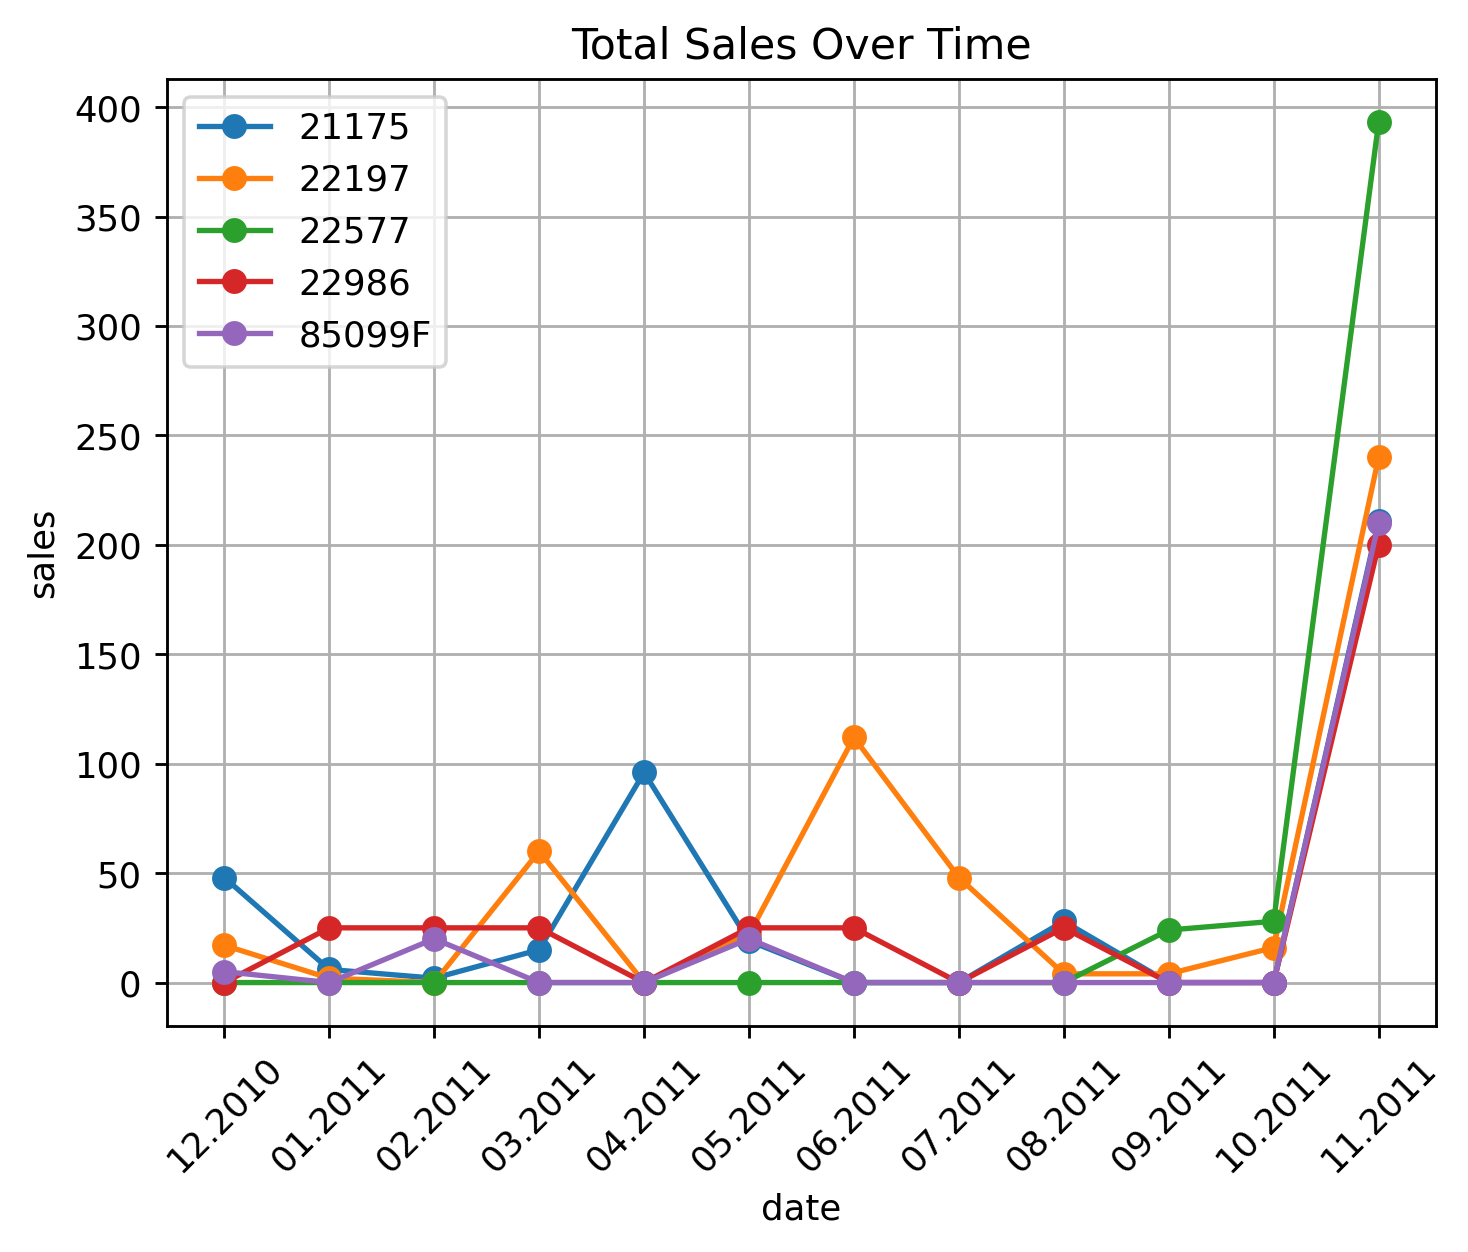

In [118]:
data_item_df = date_item_df.unstack(level="StockCode", fill_value=0)
data_item_df.columns = data_item_df.columns.droplevel()

plt.xlabel('date')
plt.ylabel('sales')
plt.title('Total Sales Over Time')

plt.plot(data_item_df.values, marker='o')
plt.xticks(
    range(len(data_item_df.index)), 
    [x.strftime('%m.%Y') for x in data_item_df.index], 
    rotation=45
)
plt.legend(data_item_df.columns)
plt.grid()

plt.show()